# ITCS 6100 - Group 12 project
## NREL Wind Integration National Dataset
### Data pulled from wtk-us.h5 file from the NREL dataset
### located: arn:aws:s3:::nrel-pds-hsds/nrel/wtk-us.h5

In [11]:
# At Terminal: Install HSDS from the HDF group to access the .h5 file
# pip install --user h5pyd
# pip install pyproj
%pip install --user h5pyd
%pip install pyproj

Looking in indexes: https://pypi.org/simple, https://pip.repos.neuron.amazonaws.com
Note: you may need to restart the kernel to use updated packages.
Looking in indexes: https://pypi.org/simple, https://pip.repos.neuron.amazonaws.com
Note: you may need to restart the kernel to use updated packages.


In [1]:
%matplotlib inline
import h5pyd
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from pyproj import Proj
import dateutil

## Save the .h5 data file so it can be viewed via Python

In [2]:
# Open the wind data "file"
# server endpoint, username, password is found via a config file
f = h5pyd.File("/nrel/wtk-us.h5", 'r', endpoint='https://developer.nrel.gov/api/hsds', bucket="nrel-pds-hsds", api_key='CG74xbnQohlDJZdN2hn0QBAZnNbKn78SMyFZWahg')

In [3]:
print(f.keys())
list(f.attrs)

KeysView(<HDF5 file "wtk-us.h5" (mode r)>)


['history']

## List of Datapoints / Features

In [4]:
# list datapoints]
list(f)

['inversemoninobukhovlength_2m',
 'status',
 'windspeed_10m',
 'temperature_80m',
 'temperature_160m',
 'temperature_200m',
 'pressure_200m',
 'DIF',
 'temperature_10m',
 'winddirection_120m',
 'windspeed_120m',
 'windspeed_140m',
 'temperature_60m',
 'relativehumidity_2m',
 'windspeed_200m',
 'temperature_140m',
 'precipitationrate_0m',
 'winddirection_160m',
 'pressure_0m',
 'GHI',
 'windspeed_80m',
 'winddirection_100m',
 'temperature_2m',
 'temperature_40m',
 'coordinates',
 'winddirection_60m',
 'windspeed_160m',
 'winddirection_40m',
 'winddirection_10m',
 'DNI',
 'winddirection_200m',
 'windspeed_60m',
 'datetime',
 'pressure_100m',
 'windspeed_40m',
 'temperature_120m',
 'windspeed_100m',
 'winddirection_140m',
 'temperature_100m',
 'winddirection_80m']

## Exploring the data
### Saving an object with just 1 feature of the dataset (windspeed_100m)

In [5]:
dset = f['windspeed_100m']

In [6]:
dt = f["datetime"]
dt = pd.DataFrame({"datetime": dt[:]},index=range(0,dt.shape[0]))
dt['datetime'] = dt['datetime'].apply(dateutil.parser.parse)

### Creating an index to see dataset from just the year 2007

In [7]:
# Index for 2007
twoThousandSeven = dt.loc[(dt.datetime >= '2007-01-01') & (dt.datetime < '2008-01-01')].index
twoThousandSeven

Int64Index([   0,    1,    2,    3,    4,    5,    6,    7,    8,    9,
            ...
            8750, 8751, 8752, 8753, 8754, 8755, 8756, 8757, 8758, 8759],
           dtype='int64', length=8760)

### Selecting a location
**In order to traverse the data by location, we need to convert location latitude and longitude into X/Y indices** <br>**Using https://www.findlatitudeandlongitude.com/ I chose Charlotte and Raleigh NC as example locations**
<br>**The function "indicesForCoord" does just that**

In [8]:
# This function finds the nearest x/y indices for a given lat/lon.
# Rather than fetching the entire coordinates database, this
# uses the Proj4 library to find a nearby point and then converts to x/y indices
def indicesForCoord(f, lat_index, lon_index):
    dset_coords = f['coordinates']
    projstring = """+proj=lcc +lat_1=30 +lat_2=60 
                    +lat_0=38.47240422490422 +lon_0=-96.0 
                    +x_0=0 +y_0=0 +ellps=sphere 
                    +units=m +no_defs """
    projectLcc = Proj(projstring)
    origin_ll = reversed(dset_coords[0][0])  # Grab origin directly from database
    origin = projectLcc(*origin_ll)
    
    coords = (lon_index,lat_index)
    coords = projectLcc(*coords)
    delta = np.subtract(coords, origin)
    ij = [int(round(x/2000)) for x in delta]
    return tuple(reversed(ij))

CharlotteNC = (35.34, -80.83)
CharlotteNC_idx = indicesForCoord( f, CharlotteNC[0], CharlotteNC[1] )

print("y,x indices for Charlotte NC: \t\t {}".format(CharlotteNC_idx))
print("Coordinates of Charlotte NC: \t {}".format(CharlotteNC))
print("Coordinates of nearest point: \t {}".format(f["coordinates"][CharlotteNC_idx[0]][CharlotteNC_idx[1]]))

y,x indices for Charlotte NC: 		 (694, 2158)
Coordinates of Charlotte NC: 	 (35.34, -80.83)
Coordinates of nearest point: 	 (35.337662, -80.83313)


In [9]:
# The 2007 timeseries data for a point in Charlotte NC
%time tseriesSeven = dset[min(twoThousandSeven):max(twoThousandSeven)+1, CharlotteNC_idx[0], CharlotteNC_idx[1]]

CPU times: user 3 ms, sys: 3.96 ms, total: 6.97 ms
Wall time: 2.55 s


## Windspeed at 100m/s in Charlotte NC - over the year 2007
### We squeeze the data down to just 1 year and 1 location, so analysis and modeling runs faster

Text(0.5, 1.0, 'Charlotte NC Windspeed in 2007')

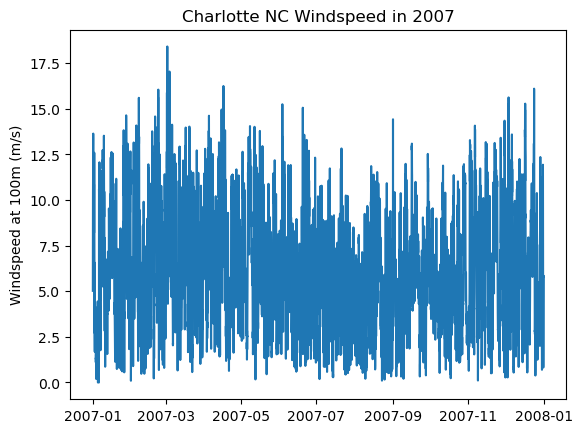

In [10]:
plt.plot(dt.iloc[twoThousandSeven,].datetime, tseriesSeven)
plt.ylabel("Windspeed at 100m (m/s)")
plt.title("Charlotte NC Windspeed in 2007")

In [11]:
# The timeseries data for all 7 years for a point in Raleigh NC
RaleighNC_idx = indicesForCoord(f, 35.78, -78.64)
%time tseries = dset[:,RaleighNC_idx[0],RaleighNC_idx[1]]

CPU times: user 5.24 ms, sys: 284 µs, total: 5.52 ms
Wall time: 15.2 s


## Windspeed at 100m/s in Raleigh NC - over the full dataset of time
### We squeeze the data down to just 1 location but keep all 7 years (2007 to 2013)

Text(0.5, 1.0, 'Raliegh NC Windspeed 2007-2013')

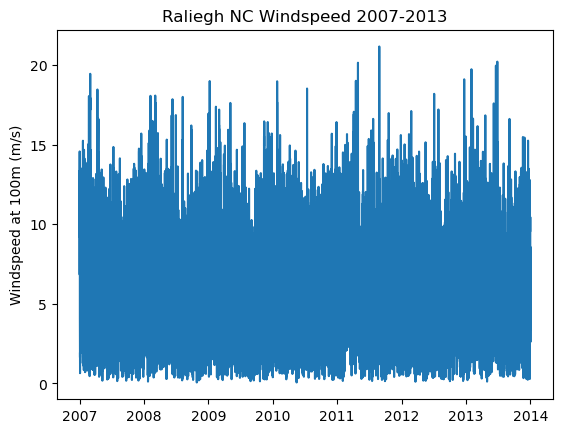

In [12]:
plt.plot(dt.datetime, tseries)
plt.ylabel("Windspeed at 100m (m/s)")
plt.title("Raliegh NC Windspeed 2007-2013")

## Saving as a DataFrame
### One way we could analyze the data without it being overwhelmingly large is feature reduction:
### Here I've reduced down to 1 feature of each type (Temperature, Windspeed, Pressure and Precipitation Rate)

In [13]:
# save 4 features in a dataframe for all dates of Charlotte NC
%time df = pd.DataFrame({"temperature_100m": f['temperature_100m'][:, CharlotteNC_idx[0], CharlotteNC_idx[1]],\
                         "windspeed_100m": f['windspeed_100m'][:, CharlotteNC_idx[0], CharlotteNC_idx[1]],\
                         "pressure_100m": f['pressure_100m'][:, CharlotteNC_idx[0], CharlotteNC_idx[1]],\
                         "precipitationrate_0m": f['precipitationrate_0m'][:, CharlotteNC_idx[0], CharlotteNC_idx[1]]},\
                         index=map(dateutil.parser.parse, f["datetime"][:]))
df.index.name = 'datetime'
df.head()

CPU times: user 2.55 s, sys: 20.5 ms, total: 2.57 s
Wall time: 1min 3s


,temperature_100m,windspeed_100m,pressure_100m,precipitationrate_0m
datetime,,,,
2007-01-01 00:00:00,287.202057,5.023346,98045.593750,0.366211
2007-01-01 01:00:00,288.172546,8.404800,97965.937500,0.366211
2007-01-01 02:00:00,288.593719,8.697777,97940.304688,0.000000
2007-01-01 03:00:00,289.243744,10.333565,97819.453125,0.000000
2007-01-01 04:00:00,290.144043,10.852379,97728.812500,24.903076


### Example scatter plot of the DataFrame (Charlotte NC): 
### Analyzing relationship between Precipitation Rate and Temperature

<AxesSubplot: xlabel='temperature_100m', ylabel='precipitationrate_0m'>

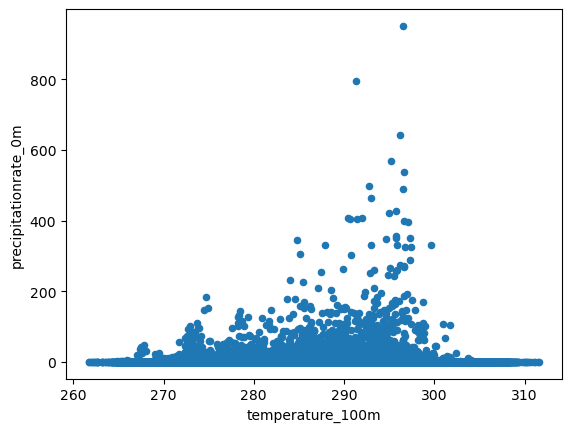

In [14]:
df.plot(x='temperature_100m', y='precipitationrate_0m', kind='scatter')

### Example bar chart of the DataFrame (Charlotte NC): 
### Analyzing the precipitation rate changing over time

<AxesSubplot: xlabel='datetime'>

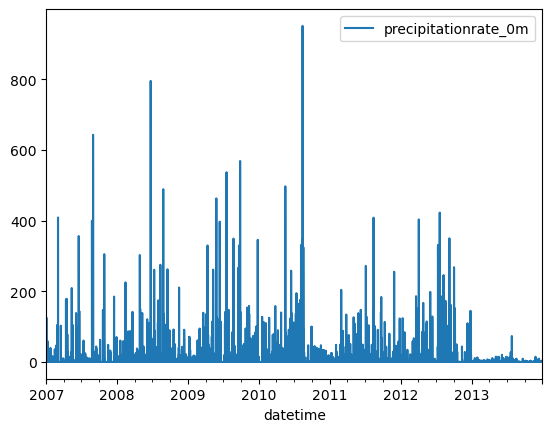

In [15]:
df.plot(y='precipitationrate_0m', use_index=True)

In [16]:
df.to_csv('CharlotteNC_Wind.csv')

### Import classes for Machine Learning

In [23]:
from sklearn import svm
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn import datasets
from sklearn.model_selection import train_test_split

In [24]:
df.head()

,temperature_100m,windspeed_100m,pressure_100m,precipitationrate_0m
datetime,,,,
2007-01-01 00:00:00,287.202057,5.023346,98045.593750,0.366211
2007-01-01 01:00:00,288.172546,8.404800,97965.937500,0.366211
2007-01-01 02:00:00,288.593719,8.697777,97940.304688,0.000000
2007-01-01 03:00:00,289.243744,10.333565,97819.453125,0.000000
2007-01-01 04:00:00,290.144043,10.852379,97728.812500,24.903076


In [26]:
# Decision Tree Regression -> windspeed_100m
X = df
Y = df["windspeed_100m"]
print(Y)

datetime
2007-01-01 00:00:00     5.023346
2007-01-01 01:00:00     8.404800
2007-01-01 02:00:00     8.697777
2007-01-01 03:00:00    10.333565
2007-01-01 04:00:00    10.852379
                         ...    
2013-12-31 19:00:00     5.224770
2013-12-31 20:00:00     4.944000
2013-12-31 21:00:00     4.657127
2013-12-31 22:00:00     5.902283
2013-12-31 23:00:00     5.847343
Name: windspeed_100m, Length: 61368, dtype: float32


In [29]:
# splitting into training and testing data
X_train, X_test, Y_train, Y_test = train_test_split(X,Y, test_size=0.2, random_state=22)

In [30]:
treeRegressionModel = DecisionTreeRegressor(random_state=22)
treeRegressionModel.fit(X_train, Y_train)
treeRegressionPredictions = treeRegressionModel.predict(X_test)

print(treeRegressionPredictions)

[5.31937408 7.48924255 4.70595551 ... 2.5025177  4.61134338 9.06399536]


In [34]:
# print(Y_test)
DTRScore = treeRegressionModel.score(X_train, Y_train)
print("R-Squared:", DTRScore)

R-Squared: 1.0


In [36]:
# It's predicting perfectly, so I must have done something wrong/this isn't a model we want to use
MSE= np.square(np.subtract(Y_test, treeRegressionPredictions)).mean()
print(MSE)

6.928007269476362e-06


[[97808.266]
 [97681.94 ]
 [97670.99 ]
 ...
 [97821.95 ]
 [97775.43 ]
 [97777.484]]


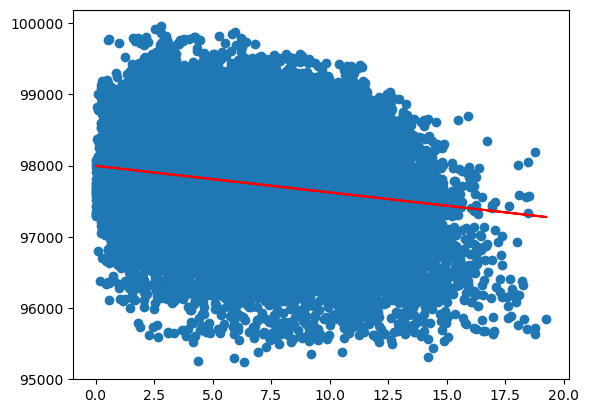

In [41]:
# Linear regression windspeed vs pressure
A = df.iloc[:, 1].values.reshape(-1, 1)
B = df.iloc[:, 2].values.reshape(-1, 1)

linearRegressionModel = LinearRegression()
linearRegressionModel.fit(A,B)
BPrediction = linearRegressionModel.predict(A)
print(BPrediction)
plt.scatter(A,B)
plt.plot(A, BPrediction, color='red')
plt.show()

In [44]:
# split above data and test it with new data/dates?
V = np.array(df["windspeed_100m"]).reshape(-1,1)
W = np.array(df["temperature_100m"]).reshape(-1,1)

V_train, V_test, W_train, W_test = train_test_split(V,W, test_size = 0.2)

LRModel = LinearRegression()
LRModel.fit(V_train, W_train)
print(LRModel.score(V_test, W_test))

0.030054854829356326


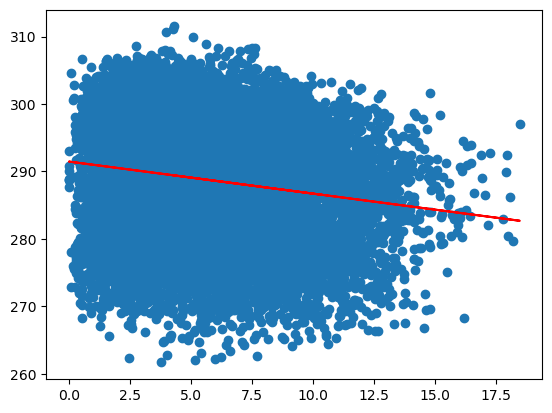

In [45]:
# predictions with the above
WPrediction = LRModel.predict(V_test)

plt.scatter(V_test, W_test)
plt.plot(V_test, WPrediction, color='red')